# Reads preprocess
Raw reads from BYO-doped pool k-seq experiments were in `.fastq.gz` format and were preprocessed using `fastq-join` or `pandaSeq` to join pair-end reads, trim primers, and then survey counts for unique reads

In [146]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode('k-seq')
dev_mode.on()

from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 240

# Repeat seq_table processing pipeline through pandaSeq joined sequence

In [193]:
from k_seq.data.seq_table import SeqTable

SeqTable.load_dataset(dataset='byo-doped', from_count_file=True, )

In [ ]:
runs = ['allow-mismatch', 'no-mismatch',
        'allow-mismatch-assembly-first', 'no-mismatch-assembly-first']

joining_results = pd.DataFrame(
    {
        run:load_joined_results(f'/mnt/storage/projects/k-seq/working/byo_doped/read_join/{run}/reads.txt')
        for run in runs
    }
)



# Raw reads

In [147]:
raw_reads = pd.read_csv('/mnt/storage/projects/k-seq/input/byo_doped/raw_reads/sample_reads.tsv', sep='\t')
sample_reads = raw_reads[raw_reads['R'] == 1].groupby('file').sum()

# Joined results

In [178]:
def rename_res(sample):
    if '_' in sample:
        # from pandaSeq or raw reads
        return sample.split('_')[0].split('-')[-1]
    else:
        # from fastq-join
        try:
            return sample.split('-')[1]
        except:
            return 'fake'
    
def get_sample_name(row):
    return row['file'].split('.')[0]

def load_joined_results(path):
    joined = pd.read_csv(path, sep='\t')
    index = joined.apply(get_sample_name, axis=1).values
    return pd.Series(data=joined['reads'].values, index=index).rename(rename_res)

In [190]:
runs = ['allow-mismatch', 'no-mismatch', 'allow-mismatch-assembly-first', 'no-mismatch-assembly-first']

joining_results = pd.DataFrame(
    {
        run:load_joined_results(f'/mnt/storage/projects/k-seq/working/byo_doped/read_join/{run}/reads.txt')
        for run in runs
    }
)
joining_results['fastq-join'] = load_joined_results('/mnt/storage/projects/k-seq/input/byo_doped/fastqs/reads.txt')[:16]
joining_results['raw-reads'] = sample_reads['reads'].rename(rename_res)

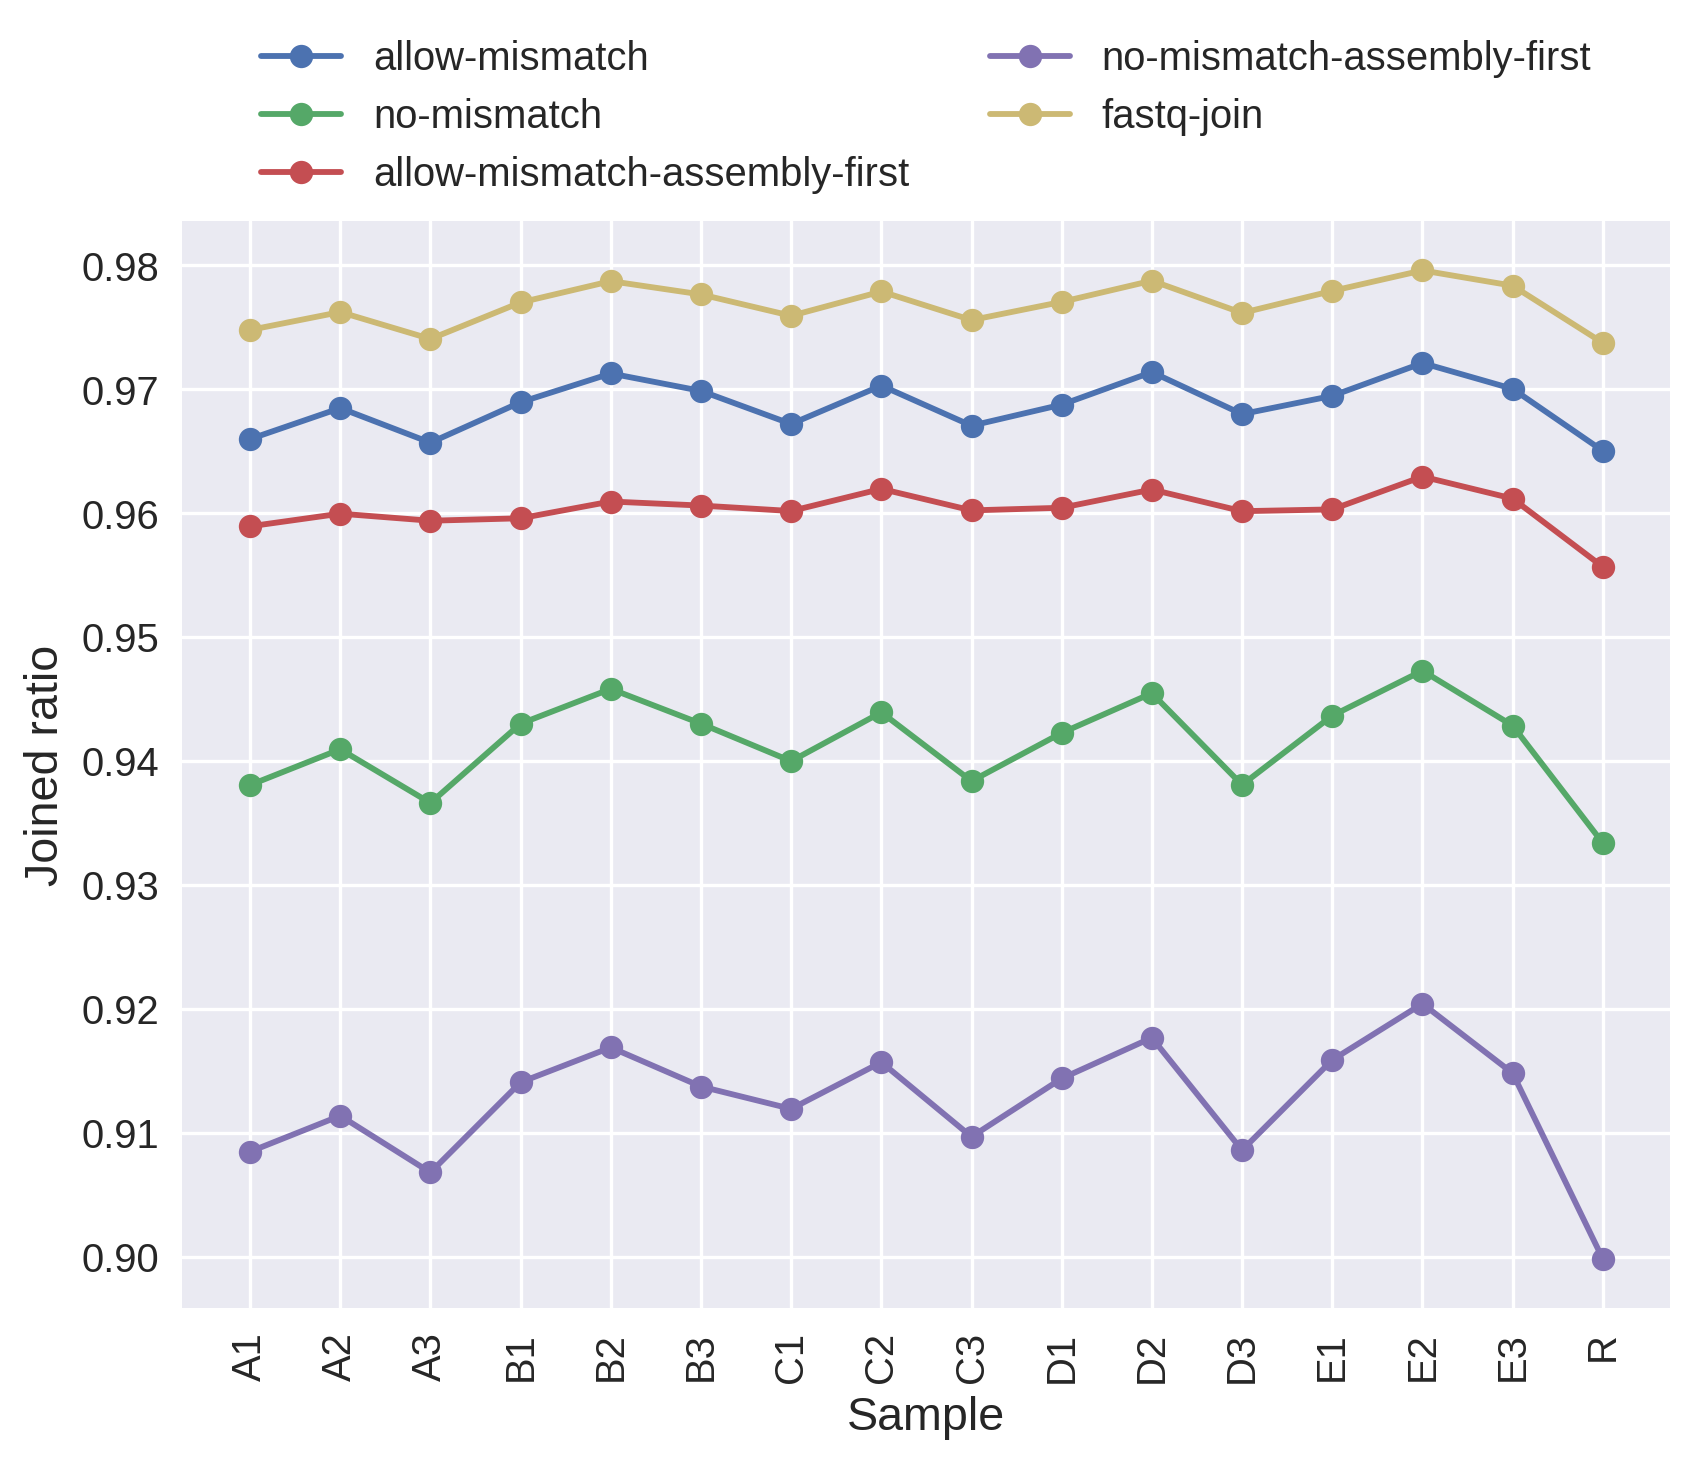

In [192]:
joined_ratio = joining_results.divide(joining_results['raw-reads'], axis=0)
                                                
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
pos = np.arange(joined_rate.shape[0])
for col in joined_ratio.columns[:-1]:
    ax.plot(pos, joined_ratio[col], marker='o', label=col)
ax.set_xticks(pos)
ax.set_xticklabels(joined_ratio.index.values, fontsize=12, rotation=90)
ax.set_ylabel('Joined ratio', fontsize=14)
ax.set_xlabel('Sample', fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize=12)
ax.tick_params(labelsize=12)
plt.show()

In [111]:
joined_rate

,allow-mismatch,allow-mismatch-assembly-first,d-A1_S1,d-A2_S6,d-A3_S11,d-B1_S2,d-B2_S7,d-B3_S12,d-C1_S3,d-C2_S8,d-C3_S13,d-D1_S4,d-D2_S9,d-D3_S14,d-E1_S5,d-E2_S10,d-E3_S15,d-R_S16,no-mismatch
d-A1_S1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d-A2_S6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d-A3_S11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d-B1_S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d-B2_S7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d-B3_S12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d-C1_S3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d-C2_S8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d-C3_S13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d-D1_S4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
